# TESLA STOCK PRICE PREDICTION

---

<h4> Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h4> Reading Dataset

In [2]:
tesla = pd.read_csv('TSLA.csv')
tesla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


Using `Open` col for prediction, and taking data **29 June 2010** to **31 Dec 2019**
<h4> Splitting the Dataset 

In [3]:
all_training_data, all_test_data = tesla.iloc[:2394], tesla.iloc[2394:]

In [4]:
training_data = np.array(all_training_data.Open).reshape(-1,1)  # reshaping data to 1-dimensional
training_data

array([[ 19.      ],
       [ 25.790001],
       [ 25.      ],
       ...,
       [435.      ],
       [428.790009],
       [405.      ]])

<h4> Scaling Training Data between 0 and 1

In [5]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler() 
training_data_scaled = normalizer.fit_transform(training_data)
training_data_scaled

array([[0.00682806],
       [0.02303873],
       [0.02115265],
       ...,
       [1.        ],
       [0.98517407],
       [0.92837702]])

<h5> Create the data to get 60 timestamps from the current instance. We chose 60
here as this will give us a sufficient number of previous instances so that we can
understand the trend; technically, this can be any number, but 60 is the optimal
value. Additionally, the upper bound value here is 2394, which is the index or
count of rows (or records) in the training set

In [6]:
timestamps = 60
upper_bound = len(training_data_scaled)
X_train, Y_train = [], []
for t in range(timestamps, upper_bound):
    X_train.append(training_data_scaled[t - timestamps: t, 0])
    Y_train.append(training_data_scaled[t, 0])
X_train, y_train = np.array(X_train), np.array(Y_train)

In [7]:
X_train

array([[0.00682806, 0.02303873, 0.02115265, ..., 0.01081507, 0.0113403 ,
        0.01129256],
       [0.02303873, 0.02115265, 0.01637779, ..., 0.0113403 , 0.01129256,
        0.00895287],
       [0.02115265, 0.01637779, 0.00921549, ..., 0.01129256, 0.00895287,
        0.00909612],
       ...,
       [0.54230529, 0.51501695, 0.5144201 , ..., 0.94456381, 0.96027309,
        0.98307311],
       [0.51501695, 0.5144201 , 0.51009885, ..., 0.96027309, 0.98307311,
        1.        ],
       [0.5144201 , 0.51009885, 0.52459054, ..., 0.98307311, 1.        ,
        0.98517407]])

In [8]:
y_train

array([0.00895287, 0.00909612, 0.01017047, ..., 1.        , 0.98517407,
       0.92837702])

Adding extra dimension to X_train

In [9]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train

array([[[0.00682806],
        [0.02303873],
        [0.02115265],
        ...,
        [0.01081507],
        [0.0113403 ],
        [0.01129256]],

       [[0.02303873],
        [0.02115265],
        [0.01637779],
        ...,
        [0.0113403 ],
        [0.01129256],
        [0.00895287]],

       [[0.02115265],
        [0.01637779],
        [0.00921549],
        ...,
        [0.01129256],
        [0.00895287],
        [0.00909612]],

       ...,

       [[0.54230529],
        [0.51501695],
        [0.5144201 ],
        ...,
        [0.94456381],
        [0.96027309],
        [0.98307311]],

       [[0.51501695],
        [0.5144201 ],
        [0.51009885],
        ...,
        [0.96027309],
        [0.98307311],
        [1.        ]],

       [[0.5144201 ],
        [0.51009885],
        [0.52459054],
        ...,
        [0.98307311],
        [1.        ],
        [0.98517407]]])

In [10]:
X_train.ndim

3

<h4> Import the following Keras libraries to build the RNN

In [11]:
from keras.src.models import Sequential
from keras.src.layers import Input, LSTM, Dense, Dropout

<h4> Set the seed and initiate the sequential model, as follows

In [12]:
from tensorflow import random
seed = 1
np.random.seed(seed)
random.set_seed(seed)
model = Sequential(name='TeslaStockPricePredictor')

<h5> input shape looks like (batch_size, time_steps, features) </h5>
<h6> Add an LSTM layer to the network with 50 units, set the return_sequences
argument to True, and set the input_shape argument to (X_train.
shape[1], 1). Add three additional LSTM layers, each with 50 units, and set
the return_sequences argument to True for the first two, as follows:

<h5> In Keras, when you're building a Sequential model, it's better to define the input shape using an Input layer as the first layer in the model. This is because the Input layer provides a more explicit and flexible way to define the input shape.

In [13]:
# Adding a first input layer
model.add(Input(shape=(60, 1)))
model.add(LSTM(units = 50, return_sequences = True))
# Adding a second LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
# Adding a third LSTM layer
model.add(LSTM(units = 50))
# Adding the output layer
model.add(Dense(units = 1))

In [14]:
model.summary()

Model: "TeslaStockPricePredictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

<h5> Compile the network with an adam optimizer and use Mean Squared Error
for the loss. Fit the model to the training data for 100 epochs with a batch size
of 32

In [15]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0531
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0020
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0018
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0016
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0015
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0015
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0013
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0012
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0010
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 9.1589e-04
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 8.1680e-04
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.4159e-04
Epoch 13/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.8532e-04
Epoch 14/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.4137e-04
Epoch 15/100
73/73 ━━━━━━━━━━━━━━━━━

In [17]:
print(f'Loss: 2.9685e-04 = {float(2.9685e-04)}')

Loss: 2.9685e-04 = 0.00029685


> To convert this back into scientific notation: `print('{:.3e}'.format(0.00029685))`

<h4> Exporting & Importing Model using pickle

In [23]:
import pickle
pickle.dump(model, open('TeslaStockPricePredictorModel.pkl', 'wb'))
pickle.load(open('TeslaStockPricePredictorModel.pkl', 'rb'))

<Sequential name=TeslaStockPricePredictor, built=True>

<h5> Load and process the test data (which is treated as actual data here) and select
the column representing the value of Open stock data

In [25]:
actual_stock_price = all_test_data[['Open']].values
actual_stock_price

array([[424.5     ],
       [440.5     ],
       [440.470001],
       [461.399994],
       [473.700012],
       [497.100006],
       [481.790009],
       [493.5     ],
       [544.26001 ],
       [529.76001 ],
       [493.75    ],
       [507.609985],
       [530.25    ],
       [571.890015],
       [564.25    ],
       [570.630005],
       [541.98999 ],
       [568.48999 ],
       [575.690002],
       [632.419983],
       [640.      ],
       [673.690002]])

In [26]:
len(actual_stock_price)

22

In [30]:
total_data = tesla.Open
total_data

0        19.000000
1        25.790001
2        25.000000
3        23.000000
4        20.000000
           ...    
2411    568.489990
2412    575.690002
2413    632.419983
2414    640.000000
2415    673.690002
Name: Open, Length: 2416, dtype: float64

<h5> Reshape and scale the input to prepare the test data. Note that we are predicting
the January & February monthly trend, January has 21 financial days where February has 1 financial day(2020-02-03) according to our data set, so in order to prepare
the test set, we take the lower bound value as 60 and the upper bound value as
82. This ensures that the difference of 22 is maintained </h5>

In [62]:
inputs = total_data[len(total_data) - len(actual_stock_price) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = normalizer.transform(inputs)
X_test = []
for t in range(timestamps, 82):
    X_test.append(inputs[t-60:t, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test

[array([0.51009885, 0.52459054, 0.53760208, 0.54705629, 0.55152078,
        0.55331136, 0.57670824, 0.57596814, 0.58816789, 0.58387054,
        0.57821226, 0.5686387 , 0.56906842, 0.67380508, 0.67225326,
        0.74344652, 0.72542136, 0.70873323, 0.70897199, 0.71665952,
        0.71303058, 0.72453802, 0.72067039, 0.74726643, 0.76006303,
        0.7826243 , 0.78966718, 0.8090054 , 0.78778108, 0.79859623,
        0.80403957, 0.80124624, 0.82094256, 0.80783558, 0.77357591,
        0.78350763, 0.76190133, 0.75199349, 0.7519696 , 0.74788711,
        0.75557464, 0.76782218, 0.75607599, 0.76125675, 0.76505275,
        0.77309839, 0.80155662, 0.80881443, 0.82344933, 0.82703048,
        0.86627988, 0.8701953 , 0.91004156, 0.94100656, 0.94456381,
        0.96027309, 0.98307311, 1.        , 0.98517407, 0.92837702]),
 array([0.52459054, 0.53760208, 0.54705629, 0.55152078, 0.55331136,
        0.57670824, 0.57596814, 0.58816789, 0.58387054, 0.57821226,
        0.5686387 , 0.56906842, 0.67380508, 0.

<h4> Predicitng Stock Price

In [50]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = normalizer.inverse_transform(predicted_stock_price)
predicted_stock_price

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


array([[402.55786],
       [424.81335],
       [435.73538],
       [436.097  ],
       [456.42633],
       [466.48615],
       [487.90753],
       [474.37808],
       [487.7409 ],
       [524.9287 ],
       [514.0254 ],
       [487.35623],
       [500.86353],
       [514.2039 ],
       [544.6865 ],
       [540.9967 ],
       [550.1843 ],
       [527.773  ],
       [549.8128 ],
       [550.2009 ],
       [588.6502 ],
       [594.3223 ]], dtype=float32)

<h5>Visualize the results by plotting the actual stock price and then plotting the
predicted stock price

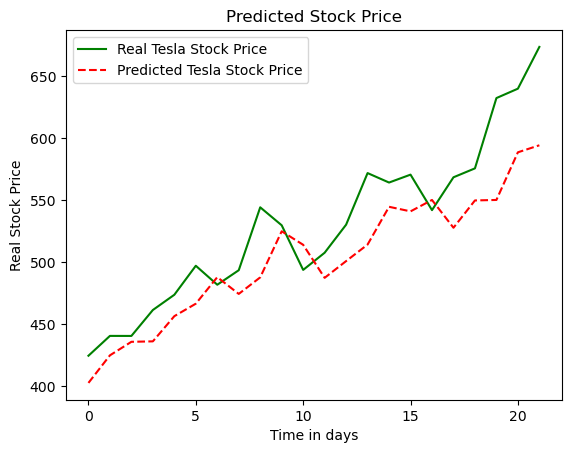

In [51]:
plt.plot(actual_stock_price, color = 'green', label = 'Real Tesla Stock Price', ls='-')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Tesla Stock Price', ls='--')
plt.title('Predicted Stock Price')
plt.xlabel('Time in days')
plt.ylabel('Real Stock Price')
plt.legend()
plt.show()

<h4> Voila! Our model was able to capture trend significantly </h4>